# Error Propagation using Random Gaussian Numbers

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 01-11-2020 (latest update)

***

The example is based on FIRST doing the error propagation analytically, and then verifying it by running a so-called Monte-Carlo (MC) program, which uses random numbers for propagating errors.

For more information on error propagation, see:
-     R. J. Barlow: page 48-61 
-     P. R. Bevington: page 36-48

***

DO THE FOLLOWING ANALYTICAL EXERCISE FIRST!!!

1. A class of students estimate by eye, that the length of the table in Auditorium A is $L = (3.5\pm 0.4)$m, and that the width is $W = (0.8\pm 0.2)$m.

   Assuming that there is no correlation between these two measurements, calculate ANALYTICALLY what the circumference (C), area (A), and diagonal (D) length is including (propagated) uncertainties. Repeat the calculation, given that the correlation between length and width is $\rho(L,W) = 0.5$ - not an unreasonable number, given that they are estimated by the same (uncertain) scale.
   
NOTE: This is a complete standard problem, that you will be asked to solve again and again in the course. For this reason, make sure that you understand how to do it, and become good at doing it reasonably fast.

In [1]:










# NOTE: Do the above analytical calculation before you continue below! Possibly using SymPy for the differentiations.











In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories

In [3]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

## Error propagation - Simulation

Now we want to try to see, if we can solve the above error propagation problem using simulation. The method is relatively straight forward: You simply take "realistic" values of the input parameters x (here Length (x1) and Width (x2)), calculate the resulting value y (here Circumference, Area, and Diagonal), and do this many times. The resulting distribution of y should be centered around the value y(x1,x2), and the standard deviation should reflect the uncertainty in y from the uncertainties in the input variables.

This is a much more clumsy of calculating the uncertainty, but comes with the advantage, that if the resulting uncertainty is not Gaussian, then one can actually see this (i.e. it avoids the assumptions used in the usual error propagation formula).

In [4]:
# First we set the parameters of the program:
N_exp = 10000           # Number of "experiments" (i.e. drawing from random distributions)
save_plots = False
r = np.random
r.seed(42)

Define parameters for two random numbers (Gaussianly distributed):

In [5]:
mu1   =  3.5
sig1  =  0.4
mu2   =  0.8
sig2  =  0.2
rho12 =  0.5           # Correlation parameter!

In [6]:
if not (-1.0 <= rho12 <= 1.0): 
    raise ValueError(f"Correlation factor not in interval [-1,1], as it is {rho12:6.2f}")

Now we calculate numbers that allows the transform from uncorrelated variables `u` and `v` to correlated random numbers `x1` and `x2` below (see Barlow page 42-44 for method):

In [7]:
# Define the parameters needed for the transformation:
theta = 0.5 * np.arctan( 2.0 * rho12 * sig1 * sig2 / ( np.square(sig1) - np.square(sig2) ) )
sigu = np.sqrt( np.abs( (((sig1*np.cos(theta))**2) - (sig2*np.sin(theta))**2 ) / ( (np.cos(theta))**2 - np.sin(theta)**2) ) )
sigv = np.sqrt( np.abs( (((sig2*np.cos(theta))**2) - (sig1*np.sin(theta))**2 ) / ( (np.cos(theta))**2 - np.sin(theta)**2) ) )

# Produce random numbers with the (possible) correlation:
u = r.normal(0.0, sigu, N_exp)
v = r.normal(0.0, sigv, N_exp)
x1_all = mu1 + np.cos(theta)*u - np.sin(theta)*v
x2_all = mu2 + np.sin(theta)*u + np.cos(theta)*v
x12_all = np.array([x1_all, x2_all])

y_all = x1_all - 2*x2_all

Note that the above is nothing more than a matrix multiplication written out! Also note that the absolute value is taken before the square root to avoid `np.sqrt(x)` with `x<0`.

Loop over process `N_exp` times: 

In [8]:
x1_all = np.zeros(N_exp)
x2_all = np.zeros_like(x1_all)
x12_all = np.zeros((N_exp, 2))
y_all = np.zeros_like(x1_all)

for i in range(N_exp): 

    # Get (uncorrelated) random Gaussian numbers u and v:
    u = r.normal(0.0, sigu)
    v = r.normal(0.0, sigv)

    # Transform into (possibly) correlated random Gaussian numbers x1 and x2:
    x1 = mu1 + np.cos(theta)*u - np.sin(theta)*v
    x2 = mu2 + np.sin(theta)*u + np.cos(theta)*v
    
    x1_all[i] = x1
    x2_all[i] = x2
    x12_all[i, :] = x1, x2
    
    # Calculate y (circumference, area or diagonal):
    y = x1-2*x2                  # Just nonsense formula! Write the appropriate formulae yourself!
    y_all[i] = y

    if (i < 5) :
        print(f"Gaussian:  x1 = {x1:4.2f}    x2 = {x2:4.2f}   ->   y ={y:5.2f}")

Gaussian:  x1 = 3.62    x2 = 0.89   ->   y = 1.85
Gaussian:  x1 = 3.10    x2 = 0.78   ->   y = 1.54
Gaussian:  x1 = 2.94    x2 = 0.52   ->   y = 1.91
Gaussian:  x1 = 2.63    x2 = 0.81   ->   y = 1.01
Gaussian:  x1 = 3.30    x2 = 1.12   ->   y = 1.07


Below is written the alternative Numpy version of the above cell:

In [9]:
u = r.normal(0.0, sigu, N_exp)
v = r.normal(0.0, sigv, N_exp)
x1_all = mu1 + np.cos(theta)*u - np.sin(theta)*v
x2_all = mu2 + np.sin(theta)*u + np.cos(theta)*v
x12_all = np.array([x1_all, x2_all])

#y_all = x1_all - 2*x2_all

***
Plot both input distribution and resulting 2D-histogram on screen:

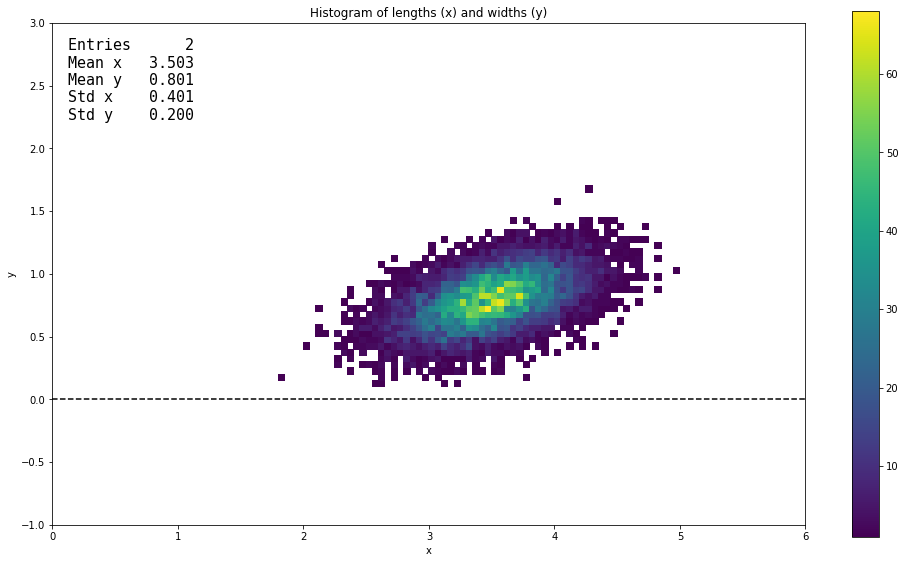

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))
counts, xedges, yedges, im = ax.hist2d(x1_all, x2_all, bins=[120, 80], range= [[0.0, 6.0], [-1.0, 3.0]], cmin=1)
ax.plot([0.0, 6.0], [0.0, 0.0], "--k")   # NOTE: This draws a line from [x1, x2], [y1, y2] with dashed line ("--") and in black ("k")
fig.colorbar(im) # ticks=[-1, 0, 1]

ax.set(title='Histogram of lengths (x) and widths (y)',
       xlabel='x', 
       ylabel='y',
       aspect='equal', # NOTE: This forces the x- and y-axis to have the SAME scale!!!
      )

d = {'Entries': len(x12_all),
     'Mean x': x1_all.mean(),
     'Mean y': x2_all.mean(),
     'Std x': x1_all.std(ddof=1),
     'Std y': x2_all.std(ddof=1),
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=15);

fig.tight_layout()
fig

if save_plots :
    fig.savefig("Dist_2Dgauss.pdf")

Now we bin `y_all` and fit it with a Gaussian distribution:

In [11]:
def gaussian(x, N, mu, sigma):
    return N * 1.0 / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

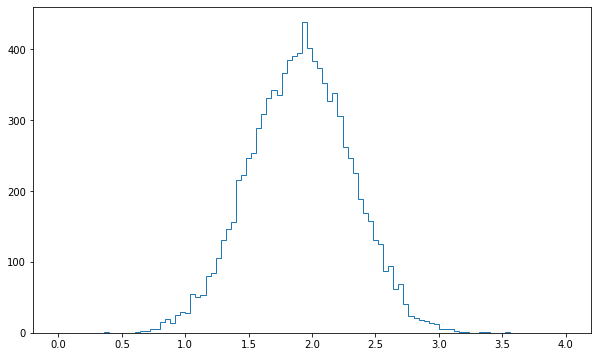

In [12]:
xmin, xmax = 0.0, 4.0

fig2, ax2 = plt.subplots(figsize=(10, 6));
counts, bin_edges, _ = ax2.hist(y_all, 100, range=(xmin, xmax), histtype='step');
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

This is the distribution of "whatever you put into it" (initially x1-2*x2), which shows what output you get and what uncertainty to expect (given by the width - think about this!). We can thus get the result by simply recording the mean and width (RMS):

In [13]:
print(f"  Mean = {y_all.mean():5.3f},    RMS = {y_all.std(ddof=1):5.3f}")

  Mean = 1.905,    RMS = 0.396


However, we are in principle not even sure, if this distribution is Gaussian, so in order to check this, we fit it. Note that in the second line (defining the Minuit object to minimised) we give "reasonable" starting values, which is key to making fitting work (more on that later).

In [14]:
Chi2_object = Chi2Regression(gaussian, bin_centers[counts>0], counts[counts>0], s_counts[counts>0])
minuit = Minuit(Chi2_object, pedantic=False, N=5000, mu=2.0, sigma=1.0, limit_sigma=(0, 10000), print_level=0) #   
minuit.migrad()                          # Perform the actual fit

for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

chi2 = minuit.fval
N_var = 3                                # Number of variables (N, mu, sigma)
N_dof = len(counts[counts>0]) - N_var    # Number of degrees of freedom

from scipy import stats
chi2_prob =  stats.chi2.sf(chi2, N_dof) # The chi2 probability given N_DOF degrees of freedom

Fit value: N = 398.05276 +/- 3.99154
Fit value: mu = 1.90438 +/- 0.00397
Fit value: sigma = 0.39399 +/- 0.00276


And plot the fit on top of the histogram:

In [15]:
xaxis = np.linspace(xmin, xmax, 1000)
yaxis = gaussian(xaxis, *minuit.args)
ax2.plot(xaxis, yaxis);

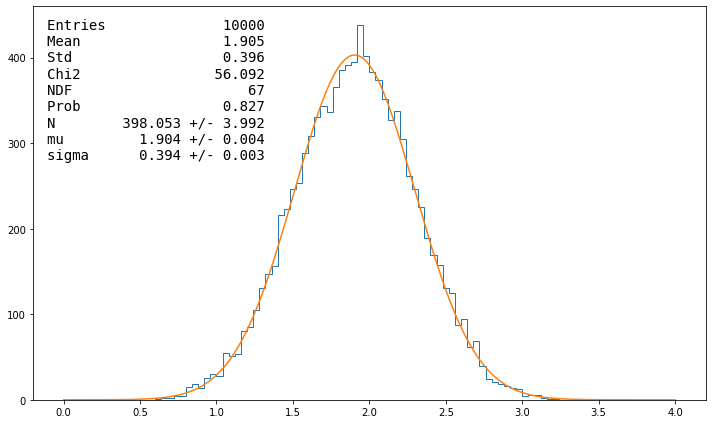

In [16]:
d = {'Entries': len(y_all),
     'Mean': y_all.mean(),
     'Std': y_all.std(ddof=1),
     'Chi2': chi2,
     'NDF': N_dof,
     'Prob': chi2_prob, 
     'N': [minuit.values['N'], minuit.errors['N']], 
     'mu': [minuit.values['mu'], minuit.errors['mu']], 
     'sigma': [minuit.values['sigma'], minuit.errors['sigma']],
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax2, fontsize=14);

fig2.tight_layout()
fig2

In [17]:
if save_plots:
    fig2.savefig("Dist_ErrorProp.pdf")

---------------------------------------------------------------------------------- 

# Questions:

0. First solve the problem of obtaining the Area, Circumference & Diagonal with uncertainty ANALYTICALLY.

1. Now look at the program, and assure yourself that you understand what is going on. Put in the correct expression for y in terms of x1=L and x2=W in order to calculate the circumference, area, and diagonal length, and run the program. Does the output correspond well with the results you expected from your analytical calculations to begin with?

2. Imagine that you wanted to know the central value and uncertainty of y1 and y2, given the
   same above PDFs for `x1`=$L$ and `x2`=$W$:
   
     `y1 = log(square(x1*tan(x2))+sqrt((x1-x2)/(cos(x2)+1.0+x1)))`
     
     `y2 = 1.1+sin(20*x1)`

   Get the central value of y, and see if you can quickly differentiate this with
   respect to `x1` and `x2`, and thus predict what uncertainty to expect for y using
   the error propagation formula. It is (for once) OK to give up on the first expression :-)
   Next, try to estimate the central value and uncertainty using random numbers
   like above - do you trust this result more? And are the distributions Gaussian?


### Advanced questions:

3. Try to generate `x1` and `x2` with e.g. a quadratic correlation, and see that despite
   not having any linear correlation, the result on circumference, area, and diagonal
   length is still affected.

---------------------------------------------------------------------------------- 